# speaker_identification
This notebook attempts to identify which character is speaking in two-character scenes. A combination of features gleaned from the frame visuals, audio, and subtitles will be used to infer the speaker.

Although we've been able to successfully cluster voices and divide the spoken dialogue audio into two voices, we need to be able to reconcile this with the two characters onscreen.

In other words: we have face A and face B, and voice M and voice N, but which face corresponds with which voice?

There's also the subtask of determining if someone is speaking at this very moment. We've previously defined a few functions to help with each.

In [1]:
import os
import pandas as pd
from dialogue_attribution_io import *

In [2]:
film = 'hobbs_shaw'
frame_choice = list(range(766, 824))
frame_folder = os.path.join('../frame_per_second', film)

In the notebook `attribution_visual.ipynb`, we were able to determine the primary character onscreen, as well as count the number of faces. We can also tell if, if there's a primary character onscreen, if their mouth is open or not.

In [3]:
primary_character_list, faces_found, mouth_open_list = frame_attribution_analysis(frame_folder, film, frame_choice)

Next, we were able to determine if there was a subtitle onscreen in `attribution_subtitle.ipynb`. This will help us determine if anyone is currently speaking.

In [4]:
sub_files = '../subtitles/hobbs_shaw.srt'
subs = load_subtitles(sub_files)

In [5]:
subtitle_onscreen = analyze_onscreen_subtitles(subs, frame_choice)

Finally, in addition to the voice clustering, we were able to determine if there isn't silence during a particular time, in `attribution_audio.ipynb`.

In [6]:
audio_file = ('../extracted_audio/prison_stereo.wav')

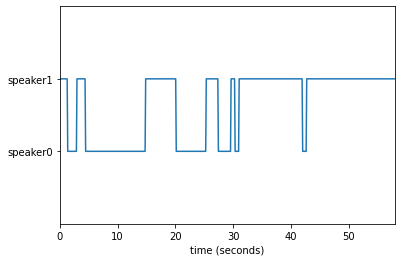

In [7]:
speaker_list = cluster_voices(audio_file)

In [8]:
audible_sound = analyze_audible_sound(audio_file)

We zip all of the information we have into a Pandas DataFrame. For each `frame_file`, representing one second of the film, we know which (arbitrary clustered) character is onscreen, which (arbitrary clustered) voice spoke last (or is currently speaking), if an onscreen character has their mouth open, if there's audible sound during this one second, and if there's a subtitle onscreen.

In [9]:
scene_df = pd.DataFrame(zip(frame_choice, faces_found, primary_character_list, mouth_open_list, speaker_list, audible_sound, subtitle_onscreen), columns=['frame_file', 'number_faces', 'primary_character', 'mouth_open', 'speaker', 'audible_sound', 'subtitle_onscreen'])

In [10]:
scene_df.head(5)

,frame_file,number_faces,primary_character,mouth_open,speaker,audible_sound,subtitle_onscreen
0,766,1,A,1,N,1,0
1,767,1,A,1,M,1,1
2,768,0,0,0,M,1,1
3,769,0,0,0,N,1,1
4,770,1,A,1,M,1,1


Since the speaker diarization (voice clustering) doesn't tell us if someone is currently speaking (only who the present speaker, or if no one is currently speaking, the last character to speak), we need to determine frames which have a character speaking. It must satisfy the following conditions:
1. There is a subtitle onscreen.
2. There is audio, not silence.

With this filter in place, we can look for "matches" in both combinations: onscreen character A with voice M, and onscreen character B with voice N, or the opposite, A-N and B-M. We also introduce this condition:
3. The onscreen character has their mouth open.

We check both combinations.

In [11]:
print('Matches for A-M:', scene_df.loc[(scene_df['mouth_open'] == 1) & (scene_df['subtitle_onscreen'] == 1) & (scene_df['audible_sound'] == 1) & (scene_df['primary_character'] == 'A') & (scene_df['speaker'] == 'M')].frame_file.size)
print('Matches for B-N:', scene_df.loc[(scene_df['mouth_open'] == 1) & (scene_df['subtitle_onscreen'] == 1) & (scene_df['audible_sound'] == 1) & (scene_df['primary_character'] == 'B') & (scene_df['speaker'] == 'N')].frame_file.size)

Matches for A-M: 9
Matches for B-N: 3


In [12]:
print('Matches for A-N:', scene_df.loc[(scene_df['mouth_open'] == 1) & (scene_df['subtitle_onscreen'] == 1) & (scene_df['audible_sound'] == 1) & (scene_df['primary_character'] == 'A') & (scene_df['speaker'] == 'N')].frame_file.size)
print('Matches for B-M:', scene_df.loc[(scene_df['mouth_open'] == 1) & (scene_df['subtitle_onscreen'] == 1) & (scene_df['audible_sound'] == 1) & (scene_df['primary_character'] == 'B') & (scene_df['speaker'] == 'M')].frame_file.size)

Matches for A-N: 4
Matches for B-M: 1


The combination of A-M and B-N had 12 matches, while the combination of A-N and B-M had 5 matches, so we match face A to voice M, and face B to voice N. This is a rough solution, but its confidence grows as we analyze additional scenes' facees and voices. We'll also be able to improve this solution as we extract more features from each data track (frame, audio, subtitles).